# K-Nearest Neighbors (KNN) – Wine Quality (binaire)

Ce notebook applique **KNN** selon le cahier des charges :
- Classifier un vin selon ses voisins les plus proches
- Sensible à la normalisation (obligatoire)
- Classification binaire : quality ≥6 → bon, <6 → moyen/mauvais
- Évaluation avec Accuracy, F1-score
- Suivi avec MLflow

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Racine du projet (dossier contenant src/ et dataset/)
_roots = [os.getcwd(), os.path.join(os.getcwd(), '..'), os.path.join(os.getcwd(), '..', '..')]
for _r in _roots:
    _p = os.path.join(os.path.abspath(_r), 'src', 'preprocessing.py')
    if os.path.isfile(_p):
        ROOT = os.path.abspath(_r)
        sys.path.insert(0, os.path.join(ROOT, 'src'))
        break
else:
    raise FileNotFoundError("Dossier 'src' introuvable. Ouvrez le projet ML-project.")
from preprocessing import load_data, clean_data, scale_features, split_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///c:/Users/pc/Desktop/ML-project/classification/mlflow.db")
mlflow.set_experiment("wine-quality-knn")

2026/02/14 17:12:54 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/14 17:12:54 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/14 17:12:54 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/14 17:12:54 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/14 17:12:54 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/14 17:12:54 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/14 17:12:54 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/14 17:12:54 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:///C:/Users/pc/Desktop/ML-project/classification/mlruns/3', creation_time=1770929462191, experiment_id='3', last_update_time=1770929462191, lifecycle_stage='active', name='wine-quality-knn', tags={}>

## 2. Chargement et preprocessing

In [2]:
df = load_data(os.path.join(ROOT, "dataset", "winequality-red.csv"))
df = clean_data(df)

# Création de la cible binaire (selon cahier des charges)
df["quality_binary"] = (df["quality"] >= 6).astype(int)

X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]

# Normalisation (très importante pour KNN)
X_scaled, scaler = scale_features(X)

# Train/test split
X_train, X_test, y_train, y_test = split_data(X_scaled, y, test_size=0.2, random_state=42)

print(f"Train set: {X_train.shape[0]} échantillons")
print(f"Test set: {X_test.shape[0]} échantillons")
print(f"Répartition classes (train): {np.bincount(y_train)}")

Train set: 1087 échantillons
Test set: 272 échantillons
Répartition classes (train): [512 575]


## 3. Test de différents k (voisins)

k=3: Accuracy=0.654, F1=0.687
k=5: Accuracy=0.688, F1=0.716
k=7: Accuracy=0.702, F1=0.725
k=9: Accuracy=0.699, F1=0.723
k=11: Accuracy=0.713, F1=0.733


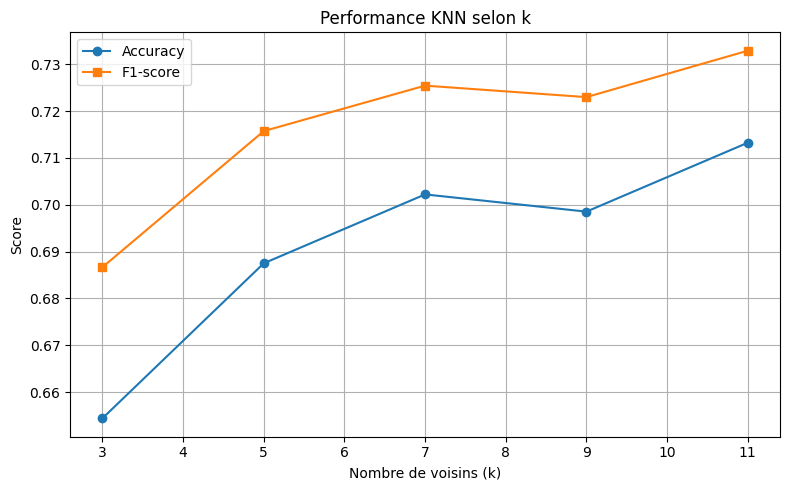

In [3]:
# Test de différents nombres de voisins
k_values = [3, 5, 7, 9, 11]
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({'k': k, 'accuracy': acc, 'f1': f1})
    print(f"k={k}: Accuracy={acc:.3f}, F1={f1:.3f}")

# Visualisation courbe de performance
results_df = pd.DataFrame(results)
plt.figure(figsize=(8, 5))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['k'], results_df['f1'], marker='s', label='F1-score')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Score')
plt.title('Performance KNN selon k')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("knn_performance.png")
plt.show()

## 4. Entraînement avec k optimal (k=5)

In [4]:
# KNN avec k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Métriques complètes
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Accuracy: 0.688
F1-score: 0.716
Precision: 0.690
Recall: 0.743

Matrice de confusion:
[[ 80  48]
 [ 37 107]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       128
           1       0.69      0.74      0.72       144

    accuracy                           0.69       272
   macro avg       0.69      0.68      0.68       272
weighted avg       0.69      0.69      0.69       272



## 5. Visualisation de la matrice de confusion

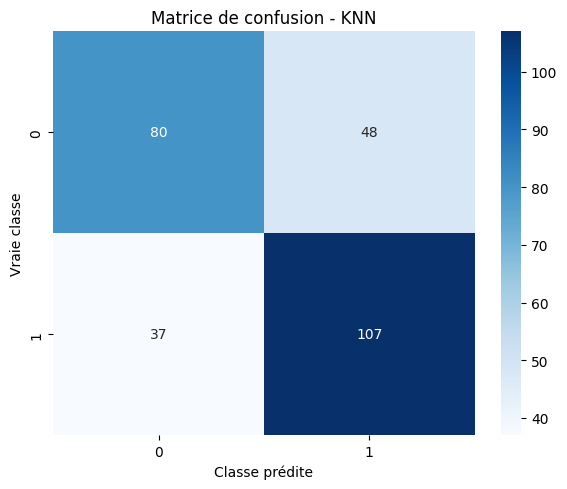

In [5]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion - KNN')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()
plt.savefig("knn_confusion_matrix.png")
plt.show()

## 6. MLflow tracking

In [6]:
with mlflow.start_run(run_name="KNN_binary"):
    mlflow.log_param("n_neighbors", k)
    mlflow.log_metric("accuracy", float(acc))
    mlflow.log_metric("f1_score", float(f1))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    mlflow.log_artifact("knn_performance.png")
    mlflow.log_artifact("knn_confusion_matrix.png")
    mlflow.sklearn.log_model(knn, "knn_model")
    print("MLflow run terminé")

2026/02/14 17:13:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\pc\anaconda3\envs\mlflow_env\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)


MLflow run terminé
